# Linear Regression Quiz
Use this Jupyter notebook to find the answer to the quiz in the previous section. There is an answer key in the next part of the lesson.

In [1]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import RegexTokenizer, CountVectorizer, IDF, StringIndexer
from pyspark.ml.feature import RegexTokenizer, VectorAssembler, Normalizer, StandardScaler, MinMaxScaler
from pyspark.sql.functions import udf, sum as Fsum, pow as Fpow, col, sqrt as Fsqrt
from pyspark.sql.types import IntegerType, FloatType
import numpy as np
import re
from pyspark.sql import functions as F
from pyspark.ml.linalg import Vectors
from pyspark.ml.regression import LinearRegression
from pyspark.ml.classification import LogisticRegression

In [2]:
spark = SparkSession.builder \
    .master("local") \
    .appName("Creating Features") \
    .getOrCreate()

### Read Dataset

In [41]:
stack_overflow_data = 'Train_onetag_small.json'

In [42]:
df = spark.read.json(stack_overflow_data)
df.persist()

DataFrame[Body: string, Id: bigint, Tags: string, Title: string, oneTag: string]

In [43]:
df.take(1)

[Row(Body="<p>I'd like to check if an uploaded file is an image file (e.g png, jpg, jpeg, gif, bmp) or another file. The problem is that I'm using Uploadify to upload the files, which changes the mime type and gives a 'text/octal' or something as the mime type, no matter which file type you upload.</p>\n\n<p>Is there a way to check if the uploaded file is an image apart from checking the file extension using PHP?</p>\n", Id=1, Tags='php image-processing file-upload upload mime-types', Title='How to check if an uploaded file is an image without mime type?', oneTag='php')]

### Build Description Length Features

In [44]:
df = df.withColumn("Desc", F.concat(F.col("Title"), F.lit(' '), F.col("Body")))

In [45]:
regexTokenizer = RegexTokenizer(inputCol="Desc", outputCol="words", pattern="\\W")
df = regexTokenizer.transform(df)
body_length = udf(lambda x: len(x), IntegerType())
split_text = udf(lambda x: x.split(" "), IntegerType())
df = df.withColumn("DescLength", body_length(df.words))
df = df.withColumn("TagLength", body_length(split_text(df.Tags)))

In [46]:
df.select(["words", "DescLength", "TagLength"]).show()

+--------------------+----------+---------+
|               words|DescLength|TagLength|
+--------------------+----------+---------+
|[how, to, check, ...|        96|        5|
|[how, can, i, pre...|        83|        1|
|[r, error, invali...|      3168|        3|
|[how, do, i, repl...|       124|        3|
|[how, to, modify,...|       154|        3|
|[setting, proxy, ...|        75|        3|
|[how, to, draw, b...|       121|        1|
|[how, to, fetch, ...|       170|        3|
|[net, library, fo...|       107|        3|
|[sql, server, pro...|        74|        5|
|[how, do, commerc...|       145|        3|
|[crappy, random, ...|       148|        3|
|[migrate, from, m...|        24|        3|
|[where, can, i, f...|        49|        3|
|[can, i, stop, wi...|        48|        1|
|[php, framework, ...|       389|        3|
|[what, creates, r...|       380|        2|
|[wpf, multiple, c...|       216|        2|
|[play, framework,...|       123|        4|
|[creating, a, rep...|       404

In [47]:
df.select("TagLength").dropDuplicates().show()

+---------+
|TagLength|
+---------+
|        1|
|        3|
|        5|
|        4|
|        2|
+---------+



In [48]:
assembler = VectorAssembler(inputCols=["DescLength"], outputCol="DescVec")
df = assembler.transform(df)
df.select(["words", "DescLength", "DescVec", "TagLength"]).show()

+--------------------+----------+--------+---------+
|               words|DescLength| DescVec|TagLength|
+--------------------+----------+--------+---------+
|[how, to, check, ...|        96|  [96.0]|        5|
|[how, can, i, pre...|        83|  [83.0]|        1|
|[r, error, invali...|      3168|[3168.0]|        3|
|[how, do, i, repl...|       124| [124.0]|        3|
|[how, to, modify,...|       154| [154.0]|        3|
|[setting, proxy, ...|        75|  [75.0]|        3|
|[how, to, draw, b...|       121| [121.0]|        1|
|[how, to, fetch, ...|       170| [170.0]|        3|
|[net, library, fo...|       107| [107.0]|        3|
|[sql, server, pro...|        74|  [74.0]|        5|
|[how, do, commerc...|       145| [145.0]|        3|
|[crappy, random, ...|       148| [148.0]|        3|
|[migrate, from, m...|        24|  [24.0]|        3|
|[where, can, i, f...|        49|  [49.0]|        3|
|[can, i, stop, wi...|        48|  [48.0]|        1|
|[php, framework, ...|       389| [389.0]|    

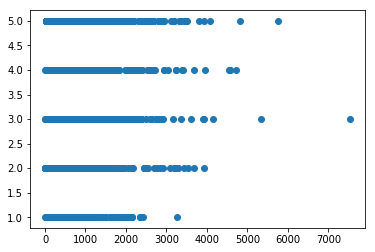

In [51]:
import matplotlib.pyplot as plt
plt.scatter(df.select("DescLength").collect(), df.select("TagLength").collect())
plt.show()

# Question
Build a linear regression model using the length of the combined Title + Body fields. What is the value of r^2 when fitting a model with `maxIter=5, regParam=0.0, fitIntercept=False, solver="normal"`?

In [58]:
data = df.select(col("DescVec").alias("features"), col("TagLength").alias("label"))

In [59]:
data.show()

+--------+-----+
|features|label|
+--------+-----+
|  [96.0]|    5|
|  [83.0]|    1|
|[3168.0]|    3|
| [124.0]|    3|
| [154.0]|    3|
|  [75.0]|    3|
| [121.0]|    1|
| [170.0]|    3|
| [107.0]|    3|
|  [74.0]|    5|
| [145.0]|    3|
| [148.0]|    3|
|  [24.0]|    3|
|  [49.0]|    3|
|  [48.0]|    1|
| [389.0]|    3|
| [380.0]|    2|
| [216.0]|    2|
| [123.0]|    4|
| [404.0]|    5|
+--------+-----+
only showing top 20 rows



In [60]:
lr = LinearRegression(maxIter=5, regParam=0.0, fitIntercept=False, solver="normal")

In [61]:
#LinearRegression(featuresCol='features', labelCol='label'
model = lr.fit(data)

In [62]:
model.coefficients

DenseVector([0.0079])

In [63]:
model_summary = model.summary

In [65]:
model_summary.r2

0.4455149596308462

In [67]:
# lr2 = LinearRegression(maxIter=5, regParam=0.0, fitIntercept=False, solver="normal")
# data2 = df.select(col("DescLength").alias("features"), col("TagLength").alias("label"))
# model2 = lr.fit(data2)
# 'requirement failed: Column features must be of type org.apache.spark.ml.linalg.VectorUDT@3bfc3ba7 but was actually IntegerType.'